#**Program to Compare Performance of Various Image Compression Methods**

In [42]:
# Importing necessary libraries
import cv2  # OpenCV for image processing
import numpy as np  # Numerical operations for array manipulation
import matplotlib.pyplot as plt  # For displaying images and visualizations
import heapq  # For Huffman coding
import os
from PIL import Image  # For handling image formats
from io import BytesIO
from sklearn.metrics import mean_squared_error
import zlib  # For Run-Length Encoding (RLE)
import matplotlib
from scipy import ndimage

##**Helper functions for each compression method**

###**1. Huffman Coding**


In [43]:
# Huffman encoding implementation to compress an image
def huffman_encoding(image):
    # Flatten the image to 1D array
    image_flat = image.flatten()

    # Frequency distribution of pixel values
    freq_dict = {i: np.sum(image_flat == i) for i in range(256)}

    # Build a priority queue
    heap = [[weight, [char, ""]] for char, weight in freq_dict.items()]
    heapq.heapify(heap)

    # Build the Huffman Tree
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    # Retrieve the codes
    huffman_dict = sorted(heap[0][1:], key=lambda p: (len(p[-1]), p))
    return huffman_dict


## 2. **Run-Length Encoding (RLE)**

In [44]:
# Run-Length Encoding compression method
def run_length_encoding(image):
    pixels = image.flatten()
    encoding = []
    prev_pixel = pixels[0]
    count = 1

    for pixel in pixels[1:]:
        if pixel == prev_pixel:
            count += 1
        else:
            encoding.append((prev_pixel, count))
            prev_pixel = pixel
            count = 1
    encoding.append((prev_pixel, count))  # Append the last pixel sequence
    return encoding

## 3. **Lempel-Ziv-Welch (LZW)**


In [45]:
def lzw_encoding(image):
    # Flatten the image into a 1D array
    pixels = image.flatten()
    dictionary = {tuple([i]): i for i in range(256)}  # Initialize the dictionary with all grayscale values
    current_string = [pixels[0]]
    compressed_data = []
    code = 256  # Start assigning new codes from 256

    for pixel in pixels[1:]:
        current_string_with_pixel = tuple(current_string + [pixel])  # Convert to a hashable type (tuple)
        if current_string_with_pixel in dictionary:
            current_string = list(current_string_with_pixel)  # Continue building the current string
        else:
            compressed_data.append(dictionary[tuple(current_string)])  # Append the code for the current string
            dictionary[current_string_with_pixel] = code  # Add new entry to the dictionary
            code += 1
            current_string = [pixel]  # Reset current string

    # Add the last string to the compressed data
    compressed_data.append(dictionary[tuple(current_string)])

    return compressed_data, dictionary


## 5. **PNG Compression**


In [46]:
# PNG compression using OpenCV (lossless)
def png_compression(image):
    result, encoded_img = cv2.imencode('.png', image, [cv2.IMWRITE_PNG_COMPRESSION, 9])
    compressed_image = cv2.imdecode(encoded_img, 1)
    return compressed_image


## 6. **WebP Compression**

In [47]:
# WebP compression (lossy or lossless)
def webp_compression(image, quality=90):
    result, encoded_img = cv2.imencode('.webp', image, [cv2.IMWRITE_WEBP_QUALITY, quality])
    compressed_image = cv2.imdecode(encoded_img, 1)
    return compressed_image


## 7. **JPEG2000 Compression**

In [48]:
# JPEG2000 compression using OpenCV (lossy and lossless)
def jpeg2000_compression(image):
    result, encoded_img = cv2.imencode('.jp2', image, [cv2.IMWRITE_JPEG2000_COMPRESSION_X1000, 10])
    compressed_image = cv2.imdecode(encoded_img, 1)
    return compressed_image


## 8. **Bitplane Slicing**

In [49]:
def bitplane_slicing(image):
    # Convert image to binary representation
    rows, cols = image.shape
    image_bin = np.unpackbits(image.astype(np.uint8).reshape(-1, 1), axis=1)  # Binary representation of each pixel
    image_bin = image_bin.reshape(rows, cols, 8)  # Reshape back to (rows, cols, 8-bit planes)

    # Extract individual bitplanes
    bit_planes = [image_bin[:, :, i] for i in range(8)]
    return bit_planes


In [56]:
# Load an example image
image_path = '/content/SeaSurfaceTemp.png'  # Update the path to your image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
print(image.shape)


(351, 706)


In [52]:
# Apply each compression method to the image
huffman_codes = huffman_encoding(image)
rle_encoded = run_length_encoding(image)
lzw_compressed = lzw_encoding(image)
jpeg_compressed = jpeg2000_compression(image)
png_compressed = png_compression(image)
webp_compressed = webp_compression(image)
jpeg2000_compressed = jpeg2000_compression(image)
bitplanes = bitplane_slicing(image)

In [53]:
# Calculate PSNR for various compression methods
psnr_values = {
    "JPEG": calculate_psnr(image, jpeg_compressed),
    "PNG": calculate_psnr(image, png_compressed),
    "WebP": calculate_psnr(image, webp_compressed),
    "JPEG2000": calculate_psnr(image, jpeg2000_compressed),
}

# Print PSNR values
for method, psnr in psnr_values.items():
    print(f"PSNR for {method}: {psnr:.2f} dB")


PSNR for JPEG: 31.76 dB
PSNR for PNG: 100.00 dB
PSNR for WebP: 45.62 dB
PSNR for JPEG2000: 31.76 dB


In [54]:
# Visualize the results
def display_images(original, compressed_images, titles):
    """
    Function to display the original and compressed images
    """
    plt.figure(figsize=(10, 10))
    plt.subplot(3, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    for i in range(len(compressed_images)):
        plt.subplot(3, 3, i+2)
        plt.imshow(compressed_images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

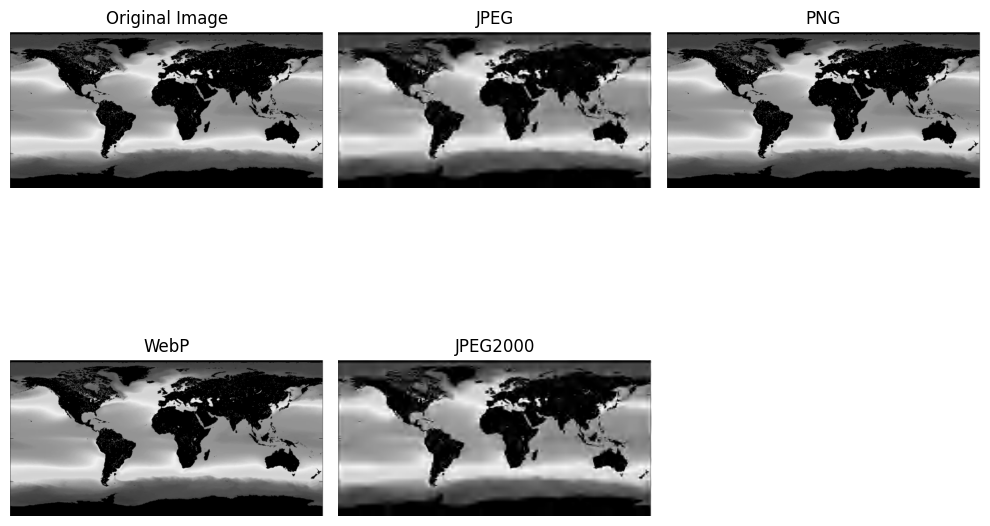

PSNR values for each compression method:
JPEG: 31.76 dB
PNG: 100.00 dB
WebP: 45.62 dB
JPEG2000: 31.76 dB


In [55]:
# Display all images
compressed_images = [
    jpeg_compressed, png_compressed, webp_compressed, jpeg2000_compressed
]
titles = ["JPEG", "PNG", "WebP", "JPEG2000"]
display_images(image, compressed_images, titles)

# Display PSNR values
print("PSNR values for each compression method:")
for method, psnr in psnr_values.items():
    print(f"{method}: {psnr:.2f} dB")